In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

#Linear Regression Model

In [3]:
# Data(XOR gate)
x = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]])     # (4, 2) 변수는 2 개 데이터는 4 개
y = torch.FloatTensor([[0], [1], [1], [0]])                 # (4, 1)

In [4]:
class LinearRegressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(2, 1, bias=True)    # 입력 x 변수의 개수가 2 개 이므로 N=2, 출력 y 변수의 개수가 1 개 이므로 M=1 이다.

  def forward(self, x):
    y = self.fc(x)

    return y

In [5]:
model = LinearRegressor()

In [6]:
# Loss Function using 'Mean Square Error'
criterion = nn.MSELoss()

In [7]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [8]:
loss_stack = []                 # 매 epoch 마다 손실 함수값을 저장하기 위해 빈 리스트로 생성(그래프를 그리기위한 용)
for epoch in range(1001):

  # H(x) 계산
  y_hat = model(x)

  # Cost 계산
  loss = criterion(y_hat, y)

  # cost 로 H(X) 개선
  optimizer.zero_grad()         # 매 epoch 마다 누적된 계산을 초기화
  loss.backward()
  optimizer.step()

  loss_stack.append(loss.item())  # 그래프를 그리기 위해 손실 함수값(.item())만 리스트에 저장함

  # 100 번 마다 로그 출력
  if epoch % 100 == 0:
    print('Epoch: {} Loss: {:.4f}'.format(
        epoch, loss.item()
    ))

Epoch: 0 Loss: 0.4632
Epoch: 100 Loss: 0.3939
Epoch: 200 Loss: 0.3554
Epoch: 300 Loss: 0.3333
Epoch: 400 Loss: 0.3199
Epoch: 500 Loss: 0.3113
Epoch: 600 Loss: 0.3052
Epoch: 700 Loss: 0.3007
Epoch: 800 Loss: 0.2969
Epoch: 900 Loss: 0.2937
Epoch: 1000 Loss: 0.2909


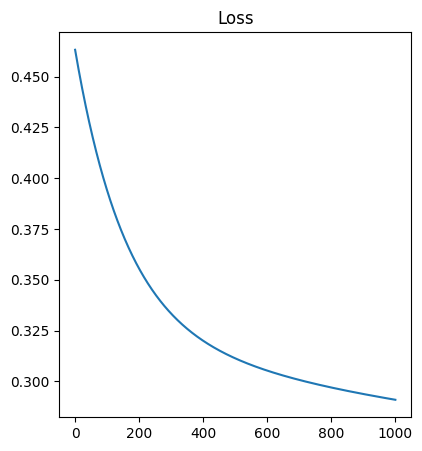

In [9]:
# Prediction
# 예측은 학습하는 것이 아니기 때문에 with torch.no_grad(): 를 통해 requires_grad 를 비활성화한다.
with torch.no_grad():
  y_hat = model(x)

  # plot
  plt.figure(figsize=(10, 5))
  plt.subplot(121)
  plt.plot(loss_stack)
  plt.title("Loss")
  plt.show()

#Multi Layer Perceptron

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
cd /content/drive/MyDrive/AI_class/Deep_learning_class

/content/drive/MyDrive/AI_class/Deep_learning_class


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [13]:
# 변수가 13개, 데이터의 개수가 506개인 데이터파일
df = pd.read_csv('./reg.csv', index_col=[0])
# 스케일링된 데이터를 불러온다.
# 이때, index_col=[0] 을 이용하여 첫번째 열에 있는 데이터의 index 는 배제하고 데이터 프레임을 만든다
# 데이터 내의 변수의 개수는 13개 이고, 인스턴스의 개수는 506 개 이다.

In [14]:
# 데이터 프레임 -> 넘파이 배열
X = df.drop('Price',axis=1).to_numpy()
# 위에서 정의한 데이터 df 에서 Price 를 제외한 나머지를 변수로 사용한다.
# drop 의 axis=1 은 열을 의미하여 Price 를 열 기준으로 배제하겠다는 의미
Y= df['Price'].to_numpy().reshape((-1, 1))
# Price 를 타겟값 Y 로 사용한다.
# 506 의 shape 를 reshape(-1, 1) 하여 -1 에는 자동으로 506 이 할당되어 (506, 1) 의 shape 를 가진다.

In [15]:
# 데이터 분할 (학습데이터 50%, 평가 데이터 50%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [16]:
# 텐서 데이터 만들기
class TensorData(Dataset):

  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data)
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0]

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)
testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)    # 대체로 학습 데이터는 shuffle=True 로 설정하고, 평가 데이터는 shuffle=False 로 설정한다.

In [17]:
# 모델 구축하기
# 1 input layer, 2 hidden layer, 1 output layer
# 데이터의 feature 가 13 이므로 input layer 의 Node 가 13개 있어야한다.
# 하나의 값으로 표현된 집값을 예측하는 것이므로 output layer 는 1 개의 Node 를 가져야한다.
# 이 모델은 각 hidden layer 마다 50개, 30개의 Node 를 가지도록 만들었다.
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13, 50, bias=True)    # input layer -> hidden layer(1)
    self.fc2 = nn.Linear(50, 30, bias=True)    # hidden layer(1) -> hidden layer(2)
    self.fc3 = nn.Linear(30, 1, bias=True)     # hidden layer(2) -> output layer
    self.dropout = nn.Dropout(0.5)             # 연산을 할 때마다 50% 의 비율로 무작위로 Node 를 제거한다.(forward function 에서 적용 위치를 정한다.)

  def forward(self, x):
    x = F.relu(self.fc1(x))                    # 선형 연산 후 ReLU function(activation function)을 적용하여 비선형적으로 변환(성능 향상)
    x = self.dropout(F.relu(self.fc2(x)))      # hidden layer(1) 에서 hidden layer(2) 로 넘어갈 떄 ReLU function 을 거치고 self.dropout 을 이용해 30개의 Node 중 50% 확률로 값을 0으로 만든다.(overfitting 방지)
    x = F.relu(self.fc3(x))
    return x                                   # batch_size 가 32 이고 출력값이 하나이므로 torch.Size([32, 1]) 인 결과를 반환한다.

In [18]:
# 모델 학습하기
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
# Adam optimization 을 사용한다.
# weight dcay 는 "가중치의 각 요소의 제곱을 합친 것”을 페널티에 쓰는 L2 regularization 에서 쓰는 기법 중에 하나이다.
# weight_decay 의 값이 클수록 제약조건이 강해진다.

In [19]:
loss_ = []                              # 그래프를 그리기위한 loss 저장용 빈 리스트 생성
n = len(trainloader)                    # 매 에폭마다 loss 값을 구하기 위해 배치 반복 수를 n 이라고 한다.

for epoch in range(400):
  running_loss = 0.0                    # 매 epoch 마다 loss 값의 평균을 구하기 위해 0으로 초기화 한다.
  for data in trainloader:              # batch 를 불러와 학습한다.
    inputs, values = data               # 입력값, 타깃값을 받는다.
    optimizer.zero_grad()
    outputs = model(inputs)             # model 에 입력값을 넣어 예측값을 구한다.
    loss = criterion(outputs, values)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()         # 매 epoch 마다 loss 값의 평균을 구하기 위해 running_loss 에 배치마다 loss 값을 더한다.
  loss_.append(running_loss/n)          # loss 저장용 리스트에 매 epoch 결과를 저장한다.
  if epoch % 10 == 0:
    print('Epoch {}/{} Cost: {:.4f}'.format(
      epoch, 400, running_loss
    ))

Epoch 0/400 Cost: 1.1220
Epoch 10/400 Cost: 0.3247
Epoch 20/400 Cost: 0.2866
Epoch 30/400 Cost: 0.2020
Epoch 40/400 Cost: 0.1700
Epoch 50/400 Cost: 0.1341
Epoch 60/400 Cost: 0.1359
Epoch 70/400 Cost: 0.0950
Epoch 80/400 Cost: 0.1165
Epoch 90/400 Cost: 0.1012
Epoch 100/400 Cost: 0.0919
Epoch 110/400 Cost: 0.0828
Epoch 120/400 Cost: 0.0747
Epoch 130/400 Cost: 0.0946
Epoch 140/400 Cost: 0.0808
Epoch 150/400 Cost: 0.0868
Epoch 160/400 Cost: 0.0811
Epoch 170/400 Cost: 0.0840
Epoch 180/400 Cost: 0.0979
Epoch 190/400 Cost: 0.0724
Epoch 200/400 Cost: 0.0694
Epoch 210/400 Cost: 0.0772
Epoch 220/400 Cost: 0.0762
Epoch 230/400 Cost: 0.0720
Epoch 240/400 Cost: 0.0673
Epoch 250/400 Cost: 0.0812
Epoch 260/400 Cost: 0.0724
Epoch 270/400 Cost: 0.0655
Epoch 280/400 Cost: 0.0745
Epoch 290/400 Cost: 0.0791
Epoch 300/400 Cost: 0.0612
Epoch 310/400 Cost: 0.0694
Epoch 320/400 Cost: 0.0822
Epoch 330/400 Cost: 0.0717
Epoch 340/400 Cost: 0.0584
Epoch 350/400 Cost: 0.0715
Epoch 360/400 Cost: 0.0568
Epoch 370/40

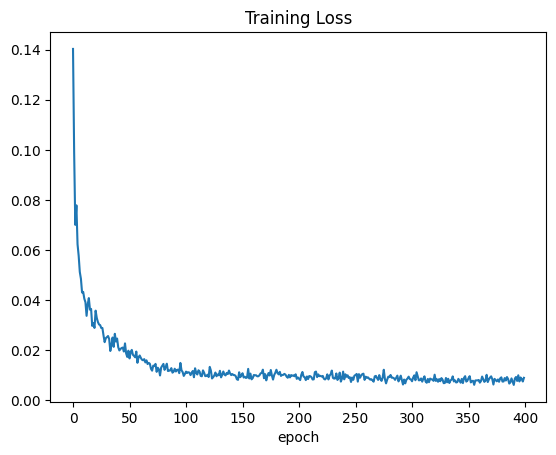

In [20]:
# loss function 그래프 그리기
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [21]:
# 모델 평가하기 (모델 평가는 Root Mean Square Error 를 사용한다.)
def evaluation(dataloader):

  predictions = torch.tensor([],dtype=torch.float)          # 예측값을 저장하기 위한 빈 리스트(그래프 그리기용)
  actual = torch.tensor([], dtype=torch.float)              # 실제값을 저장하기 위한 빈 리스트(그래프 그리기용)
  with torch.no_grad():                                     # requires_grad 비활성화
    model.eval()                                            # dropout 등과 같은 정규화 기법은 학습시에만 적용해야하므로 비활성화시키기위해 model.eval() 을 적용
    for data in dataloader:                                 # batch 단위로 데이터를 받는다.
      inputs, values = data
      outputs = model(inputs)
      predictions = torch.cat((predictions, outputs), 0)    # 0 번째 차원 기준으로 예측값과 실제값을 누적시킨다.
      actual = torch.cat((actual, values), 0)

    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual)) # MSE 에 루트를 씌워 RMSE 를 계산한다.

    return rmse

In [22]:
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

Train RMSE:  0.07629896
Test RMSE:  0.12835544
